In [1]:
import numpy as np # 계산을 위해 행렬과 같은 다양한 수학 도구를 사용하기 위한 라이브러리
import matplotlib.pyplot as plt #Plotting Libraries 학습 상태를 직관적으로 보기 위해       
import cv2 #openCV  이미지 읽고 수정하려고         
from keras.models import Sequential #순차적으로 레이어 층을 더하는 순차모델
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D # CNN(합성곱), pooling(이미지 축소)
from keras.layers import Dense, Activation, Dropout, Flatten # 과적합을 막기 위한 dropout과 효과적인 학습을 위한 라이브러리
from keras.layers.normalization import BatchNormalization # 활성화값/출력값을 정규화하여 엉뚱한 학습을 방지
from keras.callbacks import EarlyStopping, ModelCheckpoint # 상태가 최고였던 모델을 저장하기 위하여
from sklearn.model_selection import train_test_split # 테스트, 훈련 데이터 split
import glob # 폴더의 모든 하위폴더까지 탐색해서 확장자가 jpg인 파일 가져오기 위해 사용
import os # 디렉토리 없을시 생성

Using TensorFlow backend.


In [2]:
caltech_dir = "dataset/train" # 훈련 데이터 경로
categories = ["neutral","angry","surprise","smile","sad"]  # 훈련데이터 label
nb_classes = len(categories) # 분류하는 표정의 갯수

# 학습 이미지 크기
image_w = 48 
image_h = 48


X = [] # 데이터
y = [] # 레이블

#레이블 순서로 테스트 데이터를 가져옵니다.
for idx, cat in enumerate(categories):
    # 분류 클래스 길이 만큼 초기화 속하는 클래스에 참 거짓(1,0) 표현
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    

    image_dir = caltech_dir + "/" + cat #레이블에 속하는 훈련 데이터 경로 설정
    files = glob.glob(image_dir+"/*.jpg") # 해당 경로에 있는 이미지 파일 모두 가져오기

    # 훈련에 알맞에 크기를 resize 하고 흑백 전환 뒤 저장
    for i, f in enumerate(files):
        view_img = cv2.imread(f)
        view_img = cv2.cvtColor(view_img, cv2.COLOR_BGR2GRAY)
        view_img = cv2.resize(view_img,(image_w, image_h))
        X.append(view_img)
        y.append(label)


# 픽셀값을 255로 나누어 정규화해줍니다.
# 데이터의 폭이 크기 때문에 적절한 분산의 정도를 위하여
X = np.array(X)/255.0
y = np.array(y)

# model input형태에 알맞게 reshape
X = X.reshape(-1, 48, 48, 1)

# dataset을 train data와 validation data를 나누어주는 함수
# 나누는 비율 8:2로 무작위로 섞이게
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

In [3]:
#순차적으로 레이어 층을 더하는 순차모델
model = Sequential()

# 합성곱 연산을 사용하여 이미지의 픽셀을 주변의 픽셀의 조합으로 대체하는 방식입니다.
# 필터로 특징을 뽑아주는 컨볼루션(Convolution) 레이어
# Conv2D(컨볼루션 필터의 수, 행, 열, 입력 형태 : (48, 48, 1) 활성화 함수 설정 , padding 경계 처리 방법)
# same은 출력 크기를 입력과 같게 유지 (zero padding을 사용하여)
model.add(Conv2D(64, (5, 5), input_shape=(48, 48, 1),activation='relu', padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))

# 활성화값/출력값을 정규화하여 엉뚱한 학습을 방지
model.add(BatchNormalization())

# 사소한 변화를 무시하는 맥스풀링(Max Pooling) 레이어 (특징 불변성질)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 추출된 주요 특징은 2차원 데이터로 이루어져 있지만,
# 분류를 위한 학습 레이어를 위해 1차원 데이터로 바꾸어줌
model.add(Flatten())

# Dense 레이어는 입력 뉴런 수에 상관없이 출력 뉴런 수를 자유롭게 설정할 수 있기 때문에 출력층으로 많이 사용
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))


# dropout이란  몇개의 연결을 끊어서, 즉 몇개의 노드를 죽이고 
# 남은 노드들을 통해서만 훈련을 하는 것
# 학습 데이터에 대한 과적합 문제를 방지하기 위한 것
# 일부러 모델을 학습할 때 일부 노드의 activation을 지워서 다소 기억력이 떨어지는
# 모델을 만들어 문제에 대한 과적합(overfitting)을 막는다.
# 물론 검증할 때에는 모든 activation을 다시 살린다
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
    
#   학습 과정 설정
#   손실 함수 및 최적화 방법을 정의
#   다중 분류 손실함수로 적합 categorical_crossentropy (미니 배치 확률적 경사 하강법)
#   최적화 식 adma : 학습률을 줄여나가고 속도를 계산하여 학습의 갱신강도를 적응적으로 조정해나가는 방법
#   (Gradient와 Learning Rate를 수정해줌)
#   metrics : 평가기준 (accuracy 시 평가기준은 정확도)  제대로 학습되고 있는 지 확인하는 용도
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = './model'

# 디렉토리가 존재하지 않을시 생성
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
        
# 모델 저장 경로
model_path = model_dir + '/facial_expression_recognition.model'

#  훈련하는 동안 체크포인트를 저장하는 것 (에포크마다 학습된 가중치를 파일로 저장할 수 있다.)
#  모델을 재사용하거나 훈련을 이어서 할 수 있다.
#   ModelCheckpoint의 속성으로 verbose는 해당 함수의 진행 사항의 출력 여부 
#   save_best_only는 모델의 정확도가 최고값을 갱신했을 때만 저장하도록 하는 옵션
#   val_loss 값이 개선되었을때 호출된다.
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)

#    오버피팅(과적합)을 피하기 위한 기술, 상태가 최고였던 모델을 저장하기 위함
#  ‘EarlyStopping’이라는 함수를 사용하며 더 이상 개선의 여지가 없을 때 학습을 종료시키는 콜백함수    
#   개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄 것인 가를 지정
#   만약 10이라고 지정하면 개선이 없는 에포크가 10번째 지속될 경우 학습을 종료.
early_stopping = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)


In [4]:
# 학습 시작
#  X : 입력 데이터
#  Y : 결과(Label 값) 데이터
#  batch_size : 한 번에 학습할 때 사용하는 데이터 개수
#  epochs : 학습 데이터 반복 횟수 (전체 훈련 데이터 반복 횟수)
#  callbacks : 학습과 검증 과정에서 적용할 호출 리스트
#  validation_data : 학습 도중 학습의 정확도를 검증할 데이터
history = model.fit(X_train, y_train, batch_size=16, epochs=3, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 26423 samples, validate on 6606 samples
Epoch 1/3
26423/26423 [==============================] - 52s 2ms/step - loss: 1.4023 - accuracy: 0.4160 - val_loss: 1.3891 - val_accuracy: 0.4186

Epoch 00001: val_loss improved from inf to 1.38906, saving model to ./model/facial_expression_recognition.model
Epoch 2/3
26423/26423 [==============================] - 50s 2ms/step - loss: 1.1008 - accuracy: 0.5541 - val_loss: 1.0742 - val_accuracy: 0.5823

Epoch 00002: val_loss improved from 1.38906 to 1.07418, saving model to ./model/facial_expression_recognition.model
Epoch 3/3
26423/26423 [==============================] - 50s 2ms/step - loss: 0.9630 - accuracy: 0.6202 - val_loss: 0.9317 - val_accuracy: 0.6402

Epoch 00003: val_loss improved from 1.07418 to 0.93175, saving model to ./model/facial_expression_recognition.model


In [5]:
#테스트 모드에서의 모델의 손실 값과 측정항목 값을 반환합니다.
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

6606/6606 [==============================] - 3s 492us/step
정확도 : 0.6873


In [6]:
model.save('model/68.8_model.h5')

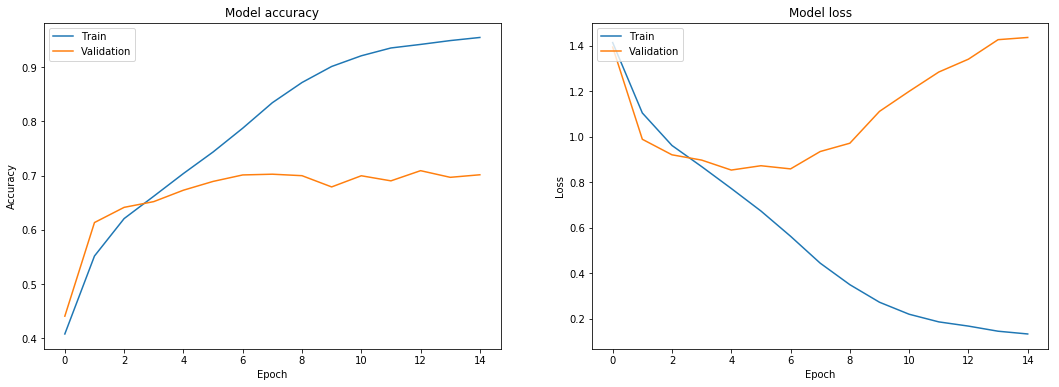

In [6]:
# 에포크 마다의 훈련 손실값 (loss)
# 에포크 마다의 훈련 정확도 (acc)
# 에포크 마다의 검증 손실값 (val_loss)
# 에포크 마다의 검증 정확도 (val_acc)

# 그래프로 표시한다면 학습 상태를 직관적으로 볼 수 있다.
# matplotlib 패키지를 이용하면 하나의 그래프로 쉽게 표시할 수 있다.

fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()